In [1]:
import os
import mne
import pyxdf
import numpy as np
%matplotlib qt
import matplotlib.pyplot as plt
matplotlib.style.use('default')

In [2]:
def closest_points_vector(eeg_timestamps, marker_timestamps):
    # Get the insertion indices for each marker timestamp
    indices = np.searchsorted(eeg_timestamps, marker_timestamps)

    # Preallocate the output array as a copy of indices.
    closest_eeg_indices = indices.copy()

    # Create a mask for markers where the insertion index equals 0 (marker before first EEG timestamp)
    mask_begin = (indices == 0)
    # For these, the closest EEG index is 0 (they cannot use a previous value)
    closest_eeg_indices[mask_begin] = 0

    # Create a mask for markers where the insertion index equals the length of the EEG timestamps
    mask_end = (indices == len(eeg_timestamps))
    # For these markers, set the closest EEG index to the last index
    closest_eeg_indices[mask_end] = len(eeg_timestamps) - 1

    # Create a mask for the "middle" markers, i.e., not at the very beginning or end
    mask_middle = (indices > 0) & (indices < len(eeg_timestamps))

    # For markers in the middle, compute the distance to the previous and next EEG timestamps:
    prev_times = eeg_timestamps[indices[mask_middle] - 1]
    next_times = eeg_timestamps[indices[mask_middle]]
    marker_times_middle = marker_timestamps[mask_middle]

    # Calculate the differences
    diff_prev = marker_times_middle - prev_times
    diff_next = next_times - marker_times_middle

    # For each marker in the middle, choose the index of the EEG timestamp that is closer:
    # If the distance to the previous timestamp is less or equal than the distance to the next,
    # then we pick indices[mask_middle]-1; otherwise, we pick indices[mask_middle].
    closest_eeg_indices[mask_middle] = np.where(diff_prev <= diff_next,
                                                indices[mask_middle] - 1,
                                                indices[mask_middle])

    return closest_eeg_indices

def create_mappings(event_names, prefix):
    marker_dict = {p: i for i, p in enumerate(
        np.unique(event_names))}
    id_binding = {v: k for k, v in marker_dict.items()}
    category_mapping = {
        p: {k: v for k, v in marker_dict.items() if k.startswith(p)} for p in prefix
    }
    return marker_dict, id_binding, category_mapping

def create_events(time_points, event_mapping, event_names):
    label_id_func = np.vectorize(event_mapping.get)
    events = np.zeros((len(time_points), 3), dtype=int)
    events[:, 0] = time_points
    events[:, 2] = label_id_func(event_names)
    return events

## EEG Observations
Missing EEG: 129059



In [3]:
subs = [797337,129059, 617834, 822866, 991031]
EXP_ROOT = "exp_data"
INPUT_ROOT = "input"
OUTPUT_ROOT = "output"
sub_id = subs[0]
DATA_FILE = os.path.join(
    EXP_ROOT, f"sub-{sub_id}", f"sub-{sub_id}_task-hearing_run-001.xdf")
RAW_VIDEO = os.path.join(INPUT_ROOT, f"{sub_id}.avi")
# DATA_FILE = os.path.join(EXP_ROOT,"elizabeth.xdf")
data, header = pyxdf.load_xdf(DATA_FILE)
print([stream['info']['type'][0] for stream in data])

Stream 4: Calculated effective sampling rate 0.0000 Hz is different from specified rate 50.0000 Hz.


['Markers', 'PPG', 'Video', 'EEG', 'EEG']


In [10]:
data[4]

{'info': defaultdict(list,
             {'name': ['obci_eeg1'],
              'type': ['EEG'],
              'channel_count': ['16'],
              'nominal_srate': ['125'],
              'channel_format': ['float32'],
              'source_id': ['openbcigui'],
              'version': ['1.1000000000000001'],
              'created_at': ['1022495.4591245'],
              'uid': ['5d6f832d-4707-4fea-8696-350831c89849'],
              'session_id': ['default'],
              'hostname': ['ESC-PC'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16572'],
              'v6service_port': ['16572'],
              'desc': [None],
              'stream_id': 1,
              'effective_srate': 125.19473749139894}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['1022619.4334859'],
               'last_timestamp': ['1023981.4369828'],


In [11]:
marker_stream = next(
    stream for stream in data if stream['info']['type'][0] == 'Markers')
# video_stream = next(
#     stream for stream in data if stream['info']['type'][0] == 'Video')
# ppg_stream = next(
#     stream for stream in data if stream['info']['type'][0] == 'PPG')
# eeg_stream = next(
#     stream for stream in data if stream['info']['type'][0] == 'EEG')
eeg_stream = data[3]

In [12]:
marker_timestamps = marker_stream['time_stamps']
marker_data = np.array(marker_stream['time_series']).squeeze()
eeg_data = eeg_stream['time_series'] * 1e-6  # convert to volts
eeg_timestamps = eeg_stream['time_stamps']
eeg_insert_points = closest_points_vector(eeg_timestamps, marker_timestamps)

In [13]:
bindings = ['pmt','hlt','let','ast']
marker_dict, id_binding, category_mapping = create_mappings(marker_data, bindings)
events = create_events(eeg_insert_points, marker_dict, marker_data)

Creating RawArray with float64 data, n_channels=16, n_times=170520
    Range : 0 ... 170519 =      0.000 ...  1364.152 secs
Ready.
Finding segments below or above PTP threshold.


Bad channels: ['R7']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 samples (6.600 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
-

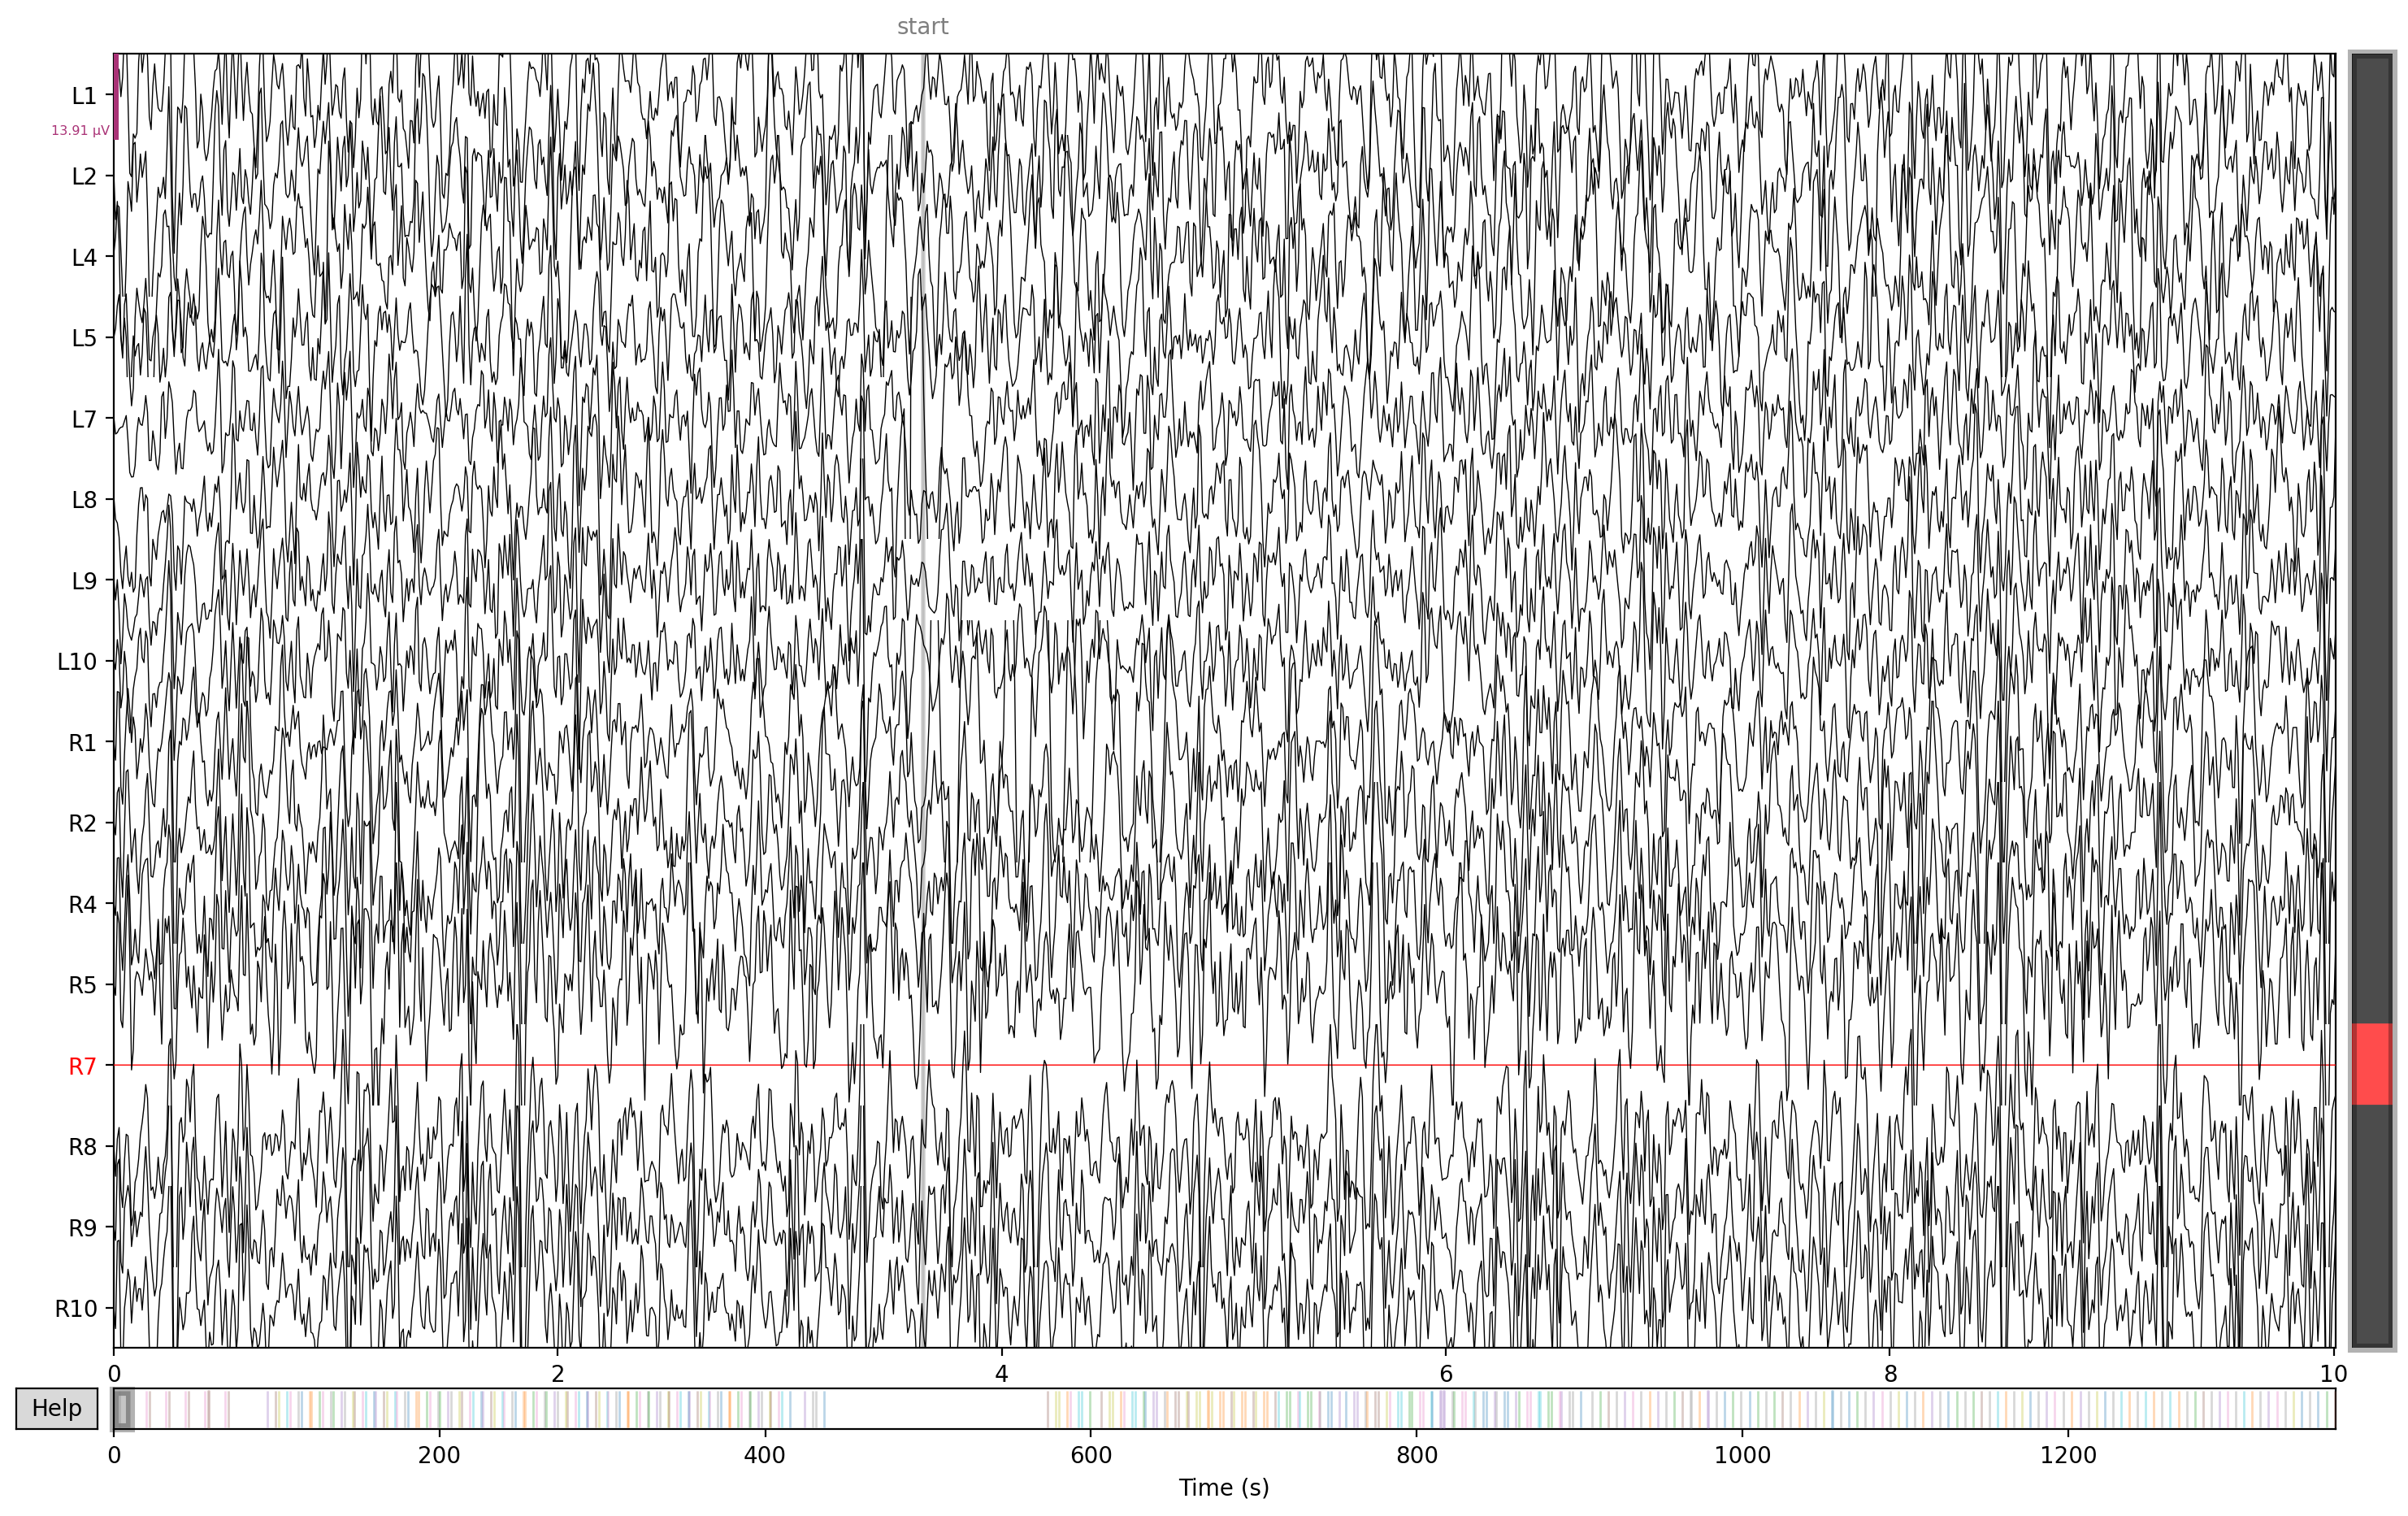

Channels marked as bad:
['R7']


In [18]:
ch_labels = ['L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L9', 'L10',
             'R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']
# ch_labels = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1',
#              'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']
sampling_rate = 125

eeg_data = eeg_stream['time_series'].T * 1e-6
info = mne.create_info(
    ch_names=ch_labels, sfreq=sampling_rate, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)
# raw.filter(l_freq=1, h_freq=None)

flalt_voltage = 0.1
_, bads = mne.preprocessing.annotate_amplitude(
    raw, flat=dict(eeg=flalt_voltage*1e-6))
raw.info['bads'] = bads
print(f"Bad channels: {bads}")
# raw.interpolate_bads()
annot = mne.annotations_from_events(
    events, raw.info['sfreq'], id_binding)
raw.set_annotations(annot)

# raw.plot_psd(fmax=62)

raw = raw.notch_filter(60)
bandpass = {'low': 1, 'high': 40}
raw = raw.filter(l_freq=bandpass['low'], h_freq=bandpass['high'])
# _, bads = mne.preprocessing.annotate_amplitude(raw, flat=dict(eeg=1e-6))
# raw.info['bads'] = ['R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']
# raw.info['bads'] = bads
# print(f"Bad channels: {bads}")

raw.plot(n_channels=16, scalings='auto', bad_color='red')
# raw.plot_psd(fmax=62,dB=True)

In [ ]:
# Compute and plot the PSD
raw.compute_psd(fmin=1, fmax=60).plot()

In [ ]:
print(raw.get_data().max())

In [ ]:
import numpy as np
import mne

# Approximate positions for 8 electrodes per ear
ch_pos = {}
radius = 0.015  # Radius around the ear (~15 mm)
angles = np.linspace(0, 2 * np.pi, 9)[:-1]  # 8 angles (0° to 315°)

# Left ear around LPA
lpa = np.array([-0.081, -0.010, 0])  # Slightly behind LPA
for i, angle in enumerate(angles):
    ch_pos[f'L{i+1}'] = [
        lpa[0],  # x: fixed at LPA's x
        lpa[1] + radius * np.cos(angle),  # y: varies in circle
        lpa[2] + radius * np.sin(angle)   # z: varies in circle
    ]

# Right ear around RPA
rpa = np.array([0.081, -0.010, 0])
for i, angle in enumerate(angles):
    ch_pos[f'R{i+1}'] = [
        rpa[0],  # x: fixed at RPA's x
        rpa[1] + radius * np.cos(angle),  # y: varies in circle
        rpa[2] + radius * np.sin(angle)   # z: varies in circle
    ]

# Create the montage
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')

# Assign channel names to match the montage
raw.rename_channels({raw.ch_names[i]: list(ch_pos.keys())[i] for i in range(16)})

# Set the montage
raw.set_montage(montage)

# Visualize the sensor positions
raw.plot_sensors()